<a href="https://colab.research.google.com/github/Pinedah/ESCOM_development-of-applications-for-data-analysis/blob/main/Tarea4_4AM1_Eq9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP de procesamiento de imagenes

In [ ]:
import torch
torch.cuda.is_available()

False

In [ ]:
import matplotlib
from sklearn.datasets import fetch_openml
'''descarga el conjunto de datos MNIST desde OpenML y lo almacena en la variable mnist.
El dataset tiene el nombre de MNIST,
Las imágenes en MNIST están aplanadas en vectores de 784 elementos (28x28 píxeles).'''
mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist["data"], mnist["target"]
X.shape, Y.shape

((70000, 784), (70000,))

In [ ]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


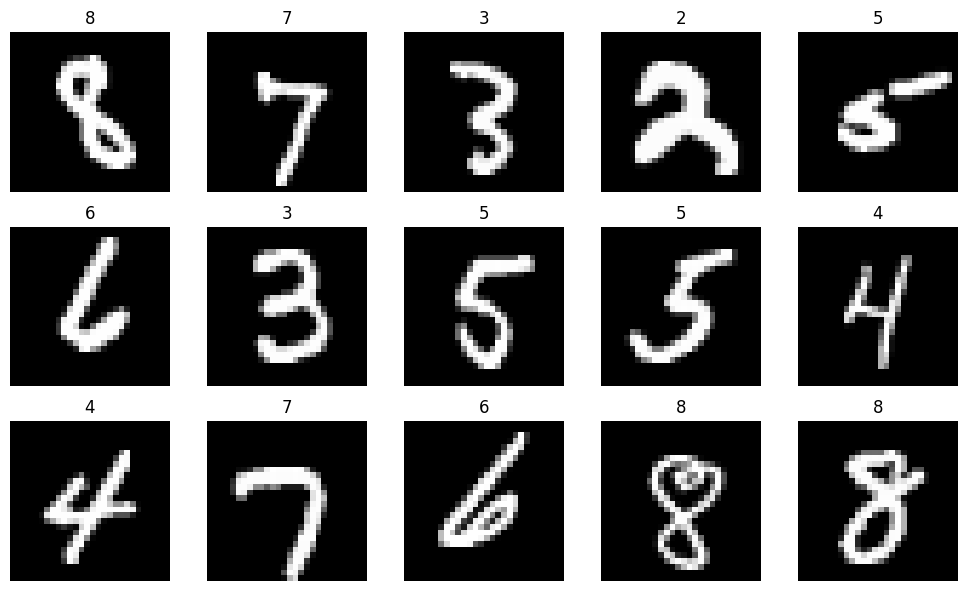

In [ ]:
#Activa la visualización de gráficos dentro de la notebook de Jupyter
%matplotlib inline
#Importar librerias necesarias
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
r, c = 3, 5
#Establece el tamaño de la figura
fig = plt.figure(figsize=(2*c, 2*r))
#Genera gráficos de las imágenes
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X.iloc[ix]
        plt.imshow(img.values.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(Y.iloc[ix])
#Ajusta el diseño.
plt.tight_layout()
#Muestra la cuadrícula de imágenes
plt.show()

In [ ]:
# normalizamos los datos mediante la division entre 255 porque los pixeles van de 0 (negro) a 255 (blanco)
import numpy as np
X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., Y[:60000].astype(np.int64), Y[60000:].astype(np.int64)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
# función de pérdida y derivada
#Calculo de la funcion softmax para comprimir un vector multidimensional en valores reales entre [0,1]
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)
#Calcula la pérdida de entropía cruzada entre la salida y el objetivo.
def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

In [ ]:
#Define las dimensiones de entrada (784 píxeles), capa oculta (100 neuronas), y salida (10 clases).
D_in, H, D_out = 784, 100, 10

# pesos del MLP
#Inicializa los pesos w1, w2 y los sesgos b1, b2 para la red
w1 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H)),
          size = (D_in, H)), requires_grad=True,  dtype=torch.float)
b1 = torch.zeros(H, requires_grad=True, dtype=torch.float)

w2 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_out+H)),
          size = (H, D_out)), requires_grad=True, dtype=torch.float)
b2 = torch.zeros(D_out, requires_grad=True, dtype=torch.float)

# Convierte los datos de entrenamiento a tensores de PyTorch
X_t = torch.from_numpy(X_train).float()
Y_t = torch.from_numpy(y_train).long()

epochs = 150
lr = 0.2
log_each = 10
l = []
for e in range(1, epochs+1):

    # forward
    h = X_t.mm(w1) + b1
    h_relu = h.clamp(min=0) # relu
    y_pred = h_relu.mm(w2) + b2

    # loss
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    with torch.no_grad():
        # update pesos
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad

        # ponemos a cero los gradientes para la siguiente iteración
        # (sino acumularíamos gradientes)
        w1.grad.zero_()
        w2.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()

    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

Epoch 10/150 Loss 1.77156
Epoch 20/150 Loss 1.35791
Epoch 30/150 Loss 1.12892
Epoch 40/150 Loss 0.98583
Epoch 50/150 Loss 0.88735
Epoch 60/150 Loss 0.81496
Epoch 70/150 Loss 0.75920
Epoch 80/150 Loss 0.71472
Epoch 90/150 Loss 0.67827
Epoch 100/150 Loss 0.64774
Epoch 110/150 Loss 0.62172
Epoch 120/150 Loss 0.59922
Epoch 130/150 Loss 0.57951
Epoch 140/150 Loss 0.56207
Epoch 150/150 Loss 0.54650


In [ ]:
#calcula la salida predicha para entradas nuevas
def evaluate(x):
    #Multiplicacion matricial entre x y w1
    h = x.mm(w1) + b1
    #Aplica la funcion ReLu (Rectified Linear Unit) en la capa oculta
    h_relu = h.clamp(min=0)
    #Multiplica la salida de la capa oculta (despues de relu) con los pesos de
    #la capa de salida w2
    y_pred = h_relu.mm(w2) + b2
    #Calcula las probabilidades y se asegura que la suma de todas sea uno
    y_probas = softmax(y_pred)
    #Encuentra el indice de la probabilidad mas alta de todas para cada entrada
    return torch.argmax(y_probas, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
#Mide la Exactitud del modelo (No. Predicciones Correctas/No. Total de predicciones)
y_pred = evaluate(torch.from_numpy(X_test).float())
accuracy_score(y_test, y_pred.cpu().numpy())

0.9134

<ipython-input-16-f4f215e0494b>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  y_pred = evaluate(torch.tensor([img]).float())[0]


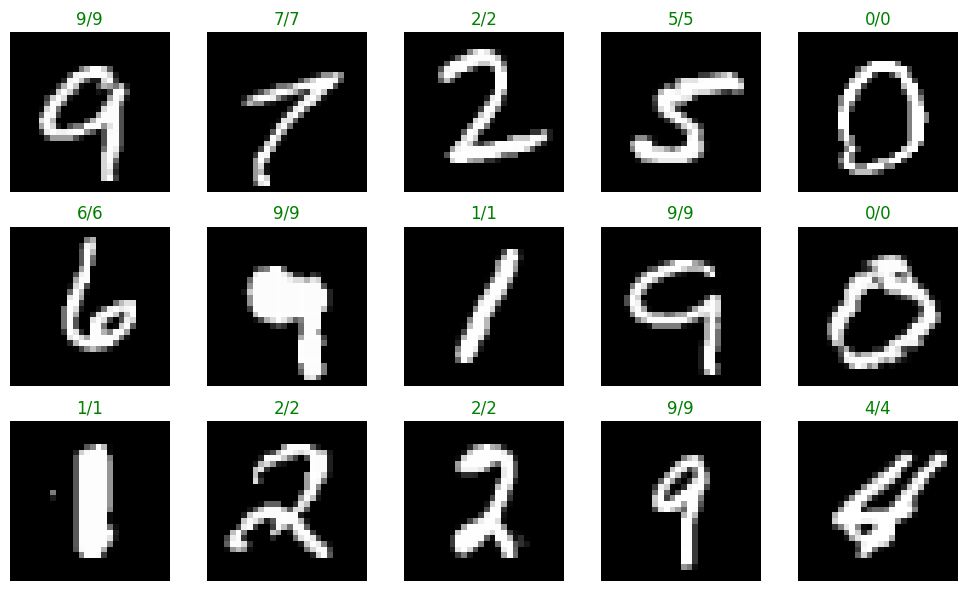

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float())[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()